In [2]:
words = open('names.txt','r').read().splitlines()

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

/home/omkar/miniconda3/envs/simpleR/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [58]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27,2))

In [8]:
emb = C[X]

In [9]:
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6,100))
b = torch.randn(100)

In [11]:
emb[:,0,:]

tensor([[ 0.6775, -1.1164],
        [ 0.6775, -1.1164],
        [ 0.6775, -1.1164],
        ...,
        [ 0.2151, -0.9518],
        [ 0.2151, -0.9518],
        [-0.8654, -0.3994]])

In [12]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([228146, 6])

In [13]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([228146, 6])

In [15]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b)
h.shape

torch.Size([228146, 100])

In [16]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts/counts.sum(1,keepdim=True)
probs.shape

torch.Size([228146, 27])

In [17]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [18]:
loss = -probs[torch.arange(32),Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [59]:
g= torch.Generator().manual_seed(214783647)
C= torch.randn((27,2),generator=g)
W1= torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2= torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in  parameters:
    p.requires_grad = True

In [60]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [63]:
lri = []
lossi = []
for i in range(10000):
    ix = torch.randint(0,Xtr.shape[0],(100,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6)@W1+b1)
    logits = h@W2+b2
    # counts = logits.exp()
    # probs = counts/counts.sum(1,keepdims=True)
    # loss = -probs[torch.arange(32),Y].log().mean()
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item())   



    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i].item())
    # lossi.append(loss.item())


 


In [64]:
loss

tensor(2.2674, grad_fn=<NllLossBackward0>)

In [66]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3774, grad_fn=<NllLossBackward0>)

In [67]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3732, grad_fn=<NllLossBackward0>)

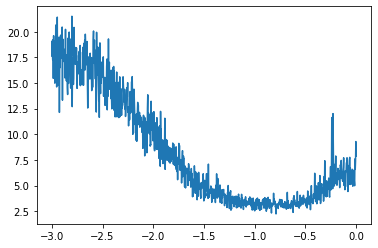

In [41]:
plt.plot(lri,lossi)

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([ 8.7682, 12.2764, 11.6778, 14.9195,  9.3772,  8.7682, 13.4567, 15.8426,
        14.0297, 12.5289, 12.7583, 11.7305,  8.7682, 13.3177,  9.9378, 11.2647,
         8.7682, 14.6622,  9.8824, 12.8135, 10.5664, 10.2610, 11.7661, 12.5193,
        16.1656,  8.7682, 12.7547, 13.0837, 12.7601, 15.8857, 11.7252, 15.3451],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

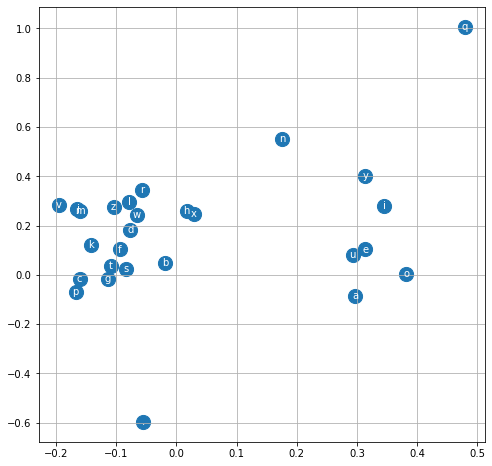

In [68]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')